# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Anne Mari Suenaga Sakai
**RA**: 822304

**Nome**: Felipe Jun Nishitani
**RA**: 822353


---
## Imports e configuração inicial

Carregamos os módulos necessários, incluindo os scripts do projeto.

In [22]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.preprocessamento import *
from scripts.analise_exploratoria import *
from scripts.experimentos import *
from scripts.analise_resultados import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Análise Exploratória 

Nesta seção realizamos a leitura inicial da base de dados e conduzimos uma análise exploratória para compreender o comportamento dos sinais fisiológicos, verificar sua qualidade e identificar padrões relevantes para a etapa de aprendizado de máquina.

A análise exploratória inclui:
- Compreensão do significado fisiológico de cada atributo
- Cálculo de medidas descritivas (média, desvio padrão, tendência, dispersão)
- Visualizações gráficas (histogramas, boxplots, correlações, distribuições por classe)
- Identificação de valores atípicos, padrões inconsistentes e redundâncias
- Avaliação das relações entre sensores (ACC × HR, HRV × EDA, etc.)


### Descrição dos Atributos da Base de Dados
A base contém atributos derivados de sensores vestíveis, representando **estatísticas agregadas** (médias, desvios padrão, energia, entropia e tendências) calculadas a partir de sinais fisiológicos registrados para cada usuário.  
Essas medições resumem informações sobre movimento, atividade autonômica, temperatura corporal e comportamento cardiovascular.  


**1. Acelerômetro (ACC)**

O acelerômetro mede a intensidade e variação do movimento corporal. É fundamental para distinguir atividade física de stress emocional, pois stress pode ocorrer mesmo com o corpo parado.

 Atributos extraídos:
- acc_mag_mean – média da magnitude do vetor de aceleração  
- acc_mag_std – desvio padrão da magnitude (variação do movimento)  
- acc_energy – energia do sinal (indicador direto da intensidade do movimento)  
- acc_entropy – entropia do movimento (complexidade e irregularidade do padrão)

 Interpretação:
- Valores altos → movimento intenso → exercício.  
- Valores baixos → pouco movimento → possível stress quando combinado a sinais autonômicos.



**2. Variabilidade Cardíaca (HRV)**

A HRV é calculada a partir dos intervalos entre batimentos cardíacos (IBI). Ela reflete o equilíbrio entre o sistema nervoso simpático (ativação) e parassimpático (relaxamento), sendo uma das métricas mais usadas para identificar stress.

 Atributos extraídos:
- hrv_rmssd – sensível às oscilações rápidas controladas pelo parassimpático  
- hrv_sdnn – variabilidade global ao longo da sessão

  Interpretação:
- HRV alta → estado calmo / recuperação.  
- HRV baixa → ativação simpática → stress emocional ou fadiga física.


**3. Atividade Eletrodérmica (EDA)**
A EDA mede a condutância da pele, que aumenta quando há ativação do sistema nervoso simpático (suor emocional). É um dos sinais fisiológicos mais fortes para detectar stress.

 Atributos extraídos:
- eda_tonic_mean – nível basal sustentado  
- eda_phasic_mean – picos rápidos de ativação  
- eda_mean – valor médio total  
- eda_std – variação e reatividade do sinal

 Interpretação:
- Valores altos ou muito variáveis → grande ativação autonômica → stress.  
- Durante exercício, EDA também sobe, mas acompanhada de movimento (ACC alto).


**4. Temperatura da Pele (TEMP)**
A temperatura periférica reflete mudanças no fluxo sanguíneo. Ela tende a aumentar no exercício (aquecimento metabólico) e diminuir no stress (vasoconstrição).

 Atributos extraídos:
- temp_mean – temperatura médio  
- temp_std – flutuação  
- temp_slope – tendência ao longo do tempo (aumento ou queda)

 Interpretação:
- Slope positivo → aumento térmico → exercício.  
- Slope negativo → queda periférica → stress.


**5. Frequência Cardíaca (HR)**
A frequência cardíaca aumenta tanto em exercícios quanto em situações de stress, mas seu comportamento se diferencia quando observada junto com ACC e HRV.

 Atributos extraídos:
- hr_mean – média da frequência cardíaca  
- hr_std – variação do sinal

 Interpretação:
- HR alta + ACC alta → exercício.  
- HR alta + ACC baixa → stress emocional.


**6. Onda de Volume de Pulso (BVP)**
O sinal BVP mede variações no volume sanguíneo periférico via fotopletismografia. Embora seja usado para derivar HR e HRV, ele também reflete perfusão e circulação periférica.

 Atributo extraído:
- bvp_mean – média do volume de pulso

 Interpretação:
- Perfusão periférica menor → possível vasoconstrição → stress.  
- Durante exercício, tende a se manter estável devido à redistribuição do fluxo sanguíneo.


In [23]:
base_path = "dataset"
df = carregar_e_resumir(base_path)


--- Carregando dataset ---

✅ Primeiras linhas do dataset:


,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,4068.866638,0.820908,63.758315,1.934911,0.020494,2.189811,-0.001937,0.514308,2.191749,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891
1,U_56491,ANAEROBIC,4208.309169,0.682113,64.493546,6.992256,0.021553,0.695010,-0.001748,0.666640,0.696758,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924
2,U_94628,ANAEROBIC,4142.529156,0.599849,64.116317,5.623789,0.009702,4.049409,-0.001584,3.069452,4.050993,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733
3,U_97819,AEROBIC,4220.643865,0.540780,64.888648,3.179186,0.029392,5.359092,-0.001485,5.371593,5.360577,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493
4,U_96956,STRESS,4188.899763,0.666053,64.686163,2.144774,0.001560,0.670497,-0.001202,0.493036,0.671699,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782



📊 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               75 non-null     object 
 1   classe           75 non-null     object 
 2   acc_energy       75 non-null     float64
 3   acc_entropy      75 non-null     float64
 4   acc_mag_mean     75 non-null     float64
 5   acc_mag_std      75 non-null     float64
 6   bvp_mean         75 non-null     float64
 7   eda_mean         75 non-null     float64
 8   eda_phasic_mean  75 non-null     float64
 9   eda_std          75 non-null     float64
 10  eda_tonic_mean   75 non-null     float64
 11  hr_mean          75 non-null     float64
 12  hr_std           75 non-null     float64
 13  hrv_rmssd        73 non-null     float64
 14  hrv_sdnn         73 non-null     float64
 15  temp_mean        74 non-null     float64
 16  temp_slope       74 non-null     float64


,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
count,75,75,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,73.000000,73.000000,74.000000,74.000000,74.000000
unique,75,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,U_79201,ANAEROBIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4300.559844,0.838452,64.888560,3.955418,0.003332,6.680819,-0.002192,3.823965,6.683011,93.882473,16.821741,0.063188,0.100189,32.369715,0.000010,0.631250
std,NaN,NaN,1675.109339,0.363718,8.257245,2.685613,0.011656,8.233190,0.001327,4.142668,8.233274,16.155851,9.073584,0.028234,0.040062,1.796072,0.000294,0.418633
min,NaN,NaN,3768.045932,0.540780,61.359069,1.076043,-0.032294,0.238126,-0.010193,0.056461,0.239361,62.228672,4.655147,0.027499,0.036318,25.295883,-0.000937,0.035736
25%,NaN,NaN,4045.069770,0.638203,63.529587,2.117531,-0.002810,1.361458,-0.002768,0.918854,1.364135,81.933728,9.794185,0.043321,0.069818,31.496474,-0.000141,0.317925
50%,NaN,NaN,4143.999590,0.710770,64.276497,3.431269,0.003114,3.690940,-0.001873,2.595732,3.692786,92.051647,16.005342,0.053799,0.094895,32.454401,0.000059,0.552936
75%,NaN,NaN,4206.539459,0.898641,64.712951,5.025788,0.009903,8.649052,-0.001390,4.991839,8.651783,105.350650,21.402240,0.073565,0.123224,33.580486,0.000167,0.868366


### Medidas Descritivas



--- Medidas Descritivas ---

📦 Distribuição das classes:


classe
ANAEROBIC    28
STRESS       25
AEROBIC      22
Name: count, dtype: int64

c:\Atividade UFSCar\6_SEMESTRE\Aprendizado de maquina\Projeto final - AM\Projeto_AM\scripts\analise_exploratoria.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  #


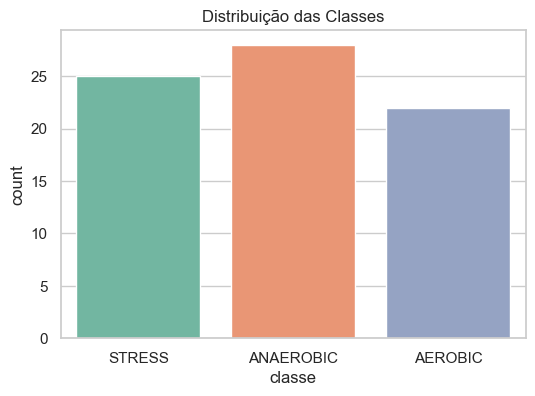


🚨 Valores ausentes por coluna:


Id                 0
classe             0
acc_energy         0
acc_entropy        0
acc_mag_mean       0
acc_mag_std        0
bvp_mean           0
eda_mean           0
eda_phasic_mean    0
eda_std            0
eda_tonic_mean     0
hr_mean            0
hr_std             0
hrv_rmssd          2
hrv_sdnn           2
temp_mean          1
temp_slope         1
temp_std           1
dtype: int64

In [24]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Medidas descritivas
# ==========================================================
medidas_descritivas(df)

### Boxplots e Histogramas

In [25]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Boxplots e Histogramas
# ==========================================================
# from scripts.analise_exploratoria import boxplots_e_histogramas
# boxplots_e_histogramas(df)

### Correlação entre Atributos



--- Matriz de Correlação ---


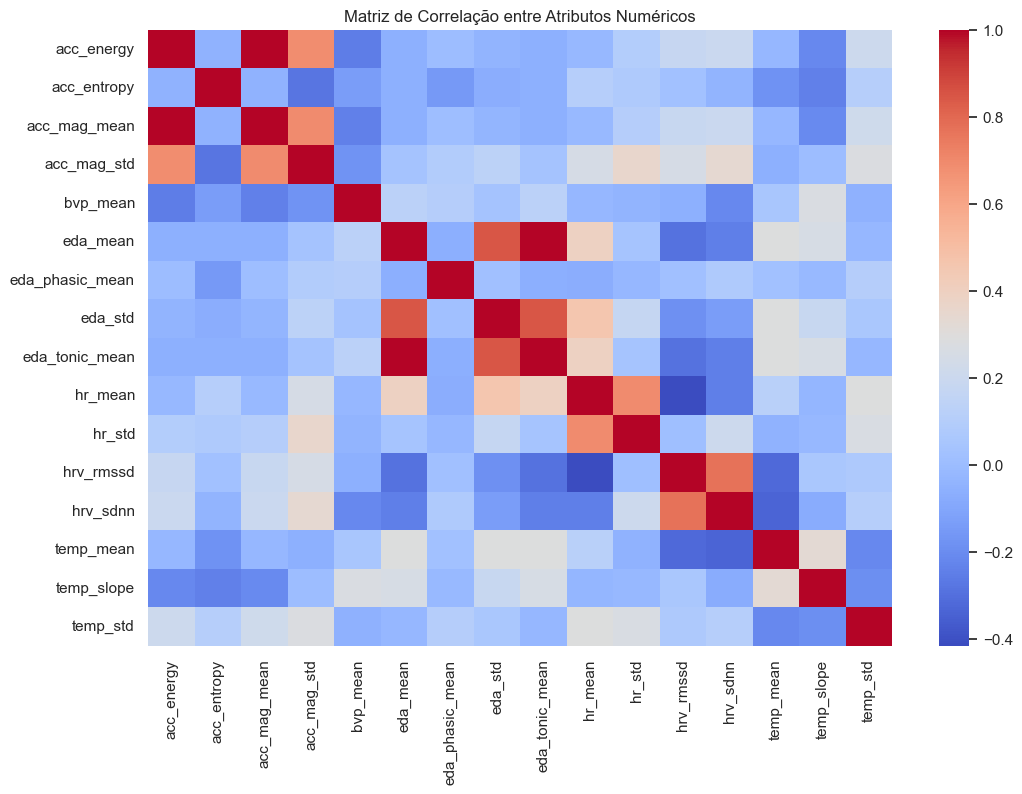


🔗 Maiores correlações:


eda_mean      eda_tonic_mean    1.000000
acc_energy    acc_mag_mean      0.999056
eda_mean      eda_std           0.849207
eda_std       eda_tonic_mean    0.849195
hrv_rmssd     hrv_sdnn          0.769044
hr_mean       hr_std            0.695529
acc_mag_mean  acc_mag_std       0.692277
acc_energy    acc_mag_std       0.690494
eda_std       hr_mean           0.463673
hr_mean       hrv_rmssd        -0.414861
dtype: float64

In [26]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Correlação entre atributos
# ==========================================================
correlacao_atributos(df)


### Pairplot Amostrado


--- Pairplot Amostrado ---
Gerando pairplot com 75 amostras e 5 atributos...


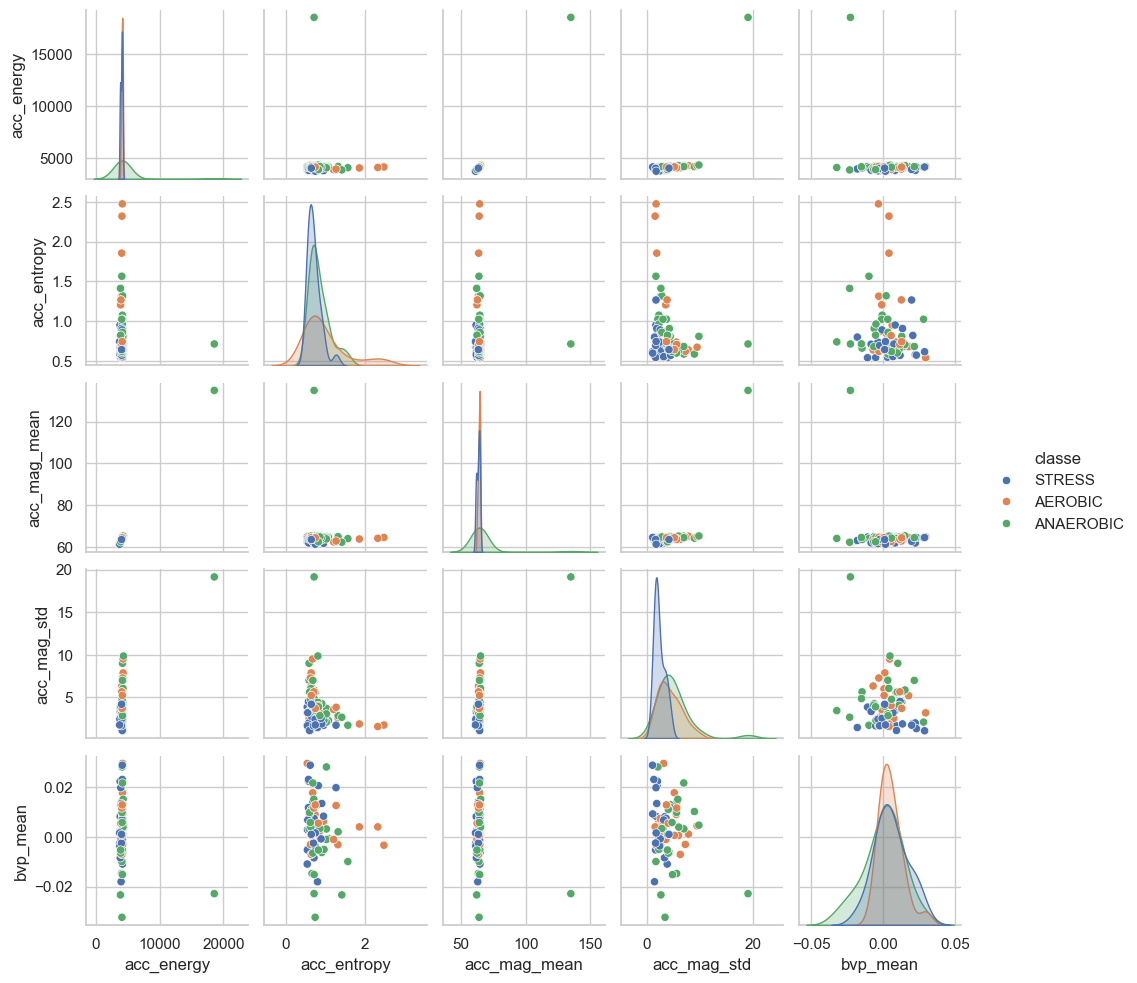

In [27]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Pairplot amostrado
# ==========================================================
pairplot_amostrado(df)


### Séries Temporais
Foram plotadas as séries agregadas de cada sensor (HR, HRV, EDA, ACC e temperatura) ao longo das amostras. Esses gráficos permitem identificar padrões globais entre os participantes, como variações amplas na atividade eletrodérmica e na frequência cardíaca, frequentemente associadas a estados de estresse, bem como valores mais elevados de aceleração média em casos de exercícios aeróbicos e anaeróbicos.

TEXTO DE INTERPRETACAO DOS GRAFICOS MAIS IMPORTANTES 
(exemplo: Os gráficos temporais permitiram observar tendências gerais nos sinais fisiológicos. Picos repentinos em HR e ACC indicam episódios de esforço físico, enquanto aumentos abruptos em EDA refletem respostas de estresse agudo. Já quedas graduais em temperatura são consistentes com a literatura sobre vasoconstrição induzida por estresse. A variabilidade entre amostras também revelou perfis distintos de ativação fisiológica entre os participantes.)
(como analisar abaixo)

In [28]:
# plot_series_temporais(df, [
#     "hr_mean",
#     "hrv_rmssd",
#     "eda_mean",
#     "eda_phasic_mean",
#     "temp_mean"
# ])


### Scatter Duplo
Também foram analisadas relações entre pares de sensores, como HR × EDA, ACC × HR e HRV × EDA. Os gráficos de dispersão revelam separações naturais entre os estados fisiológicos: indivíduos em condição de estresse tendem a apresentar EDA elevada combinada com RMSSD reduzido, enquanto atividades aeróbicas e anaeróbicas apresentam maior magnitude de aceleração e frequência cardíaca, porém com diferentes assinaturas eletrodérmicas.

Os gráficos de dispersão mostraram relações importantes entre sensores. O par HR × EDA evidenciou um agrupamento de indivíduos com ambos os valores elevados, sugerindo estados de alto arousal fisiológico, típicos de estresse. A relação inversa entre HRV e EDA phasic indica diminuição da atividade parassimpática em situações de estresse. Já ACC × HR ajudou a diferenciar claramente atividades físicas de episódios de estresse, já que esforço físico tende a aumentar simultaneamente aceleração e frequência cardíaca.

In [29]:
# scatter_duplo(df, "hr_mean", "eda_mean")
# scatter_duplo(df, "hrv_rmssd", "eda_phasic_mean")
# scatter_duplo(df, "acc_mag_mean", "hr_mean")
# scatter_duplo(df, "temp_mean", "eda_mean")


---
## Pré-processamento

Com base na análise exploratória, aplicamos técnicas de pré-processamento para melhorar a qualidade e a utilidade dos dados antes do treinamento dos modelos:
- Tratamento de valores faltantes
- Remoção de atributos redundantes
- Normalização e padronização de variáveis numéricas
- Transformações logarítmicas para estabilização de variância
- Limitação de outliers
- Engenharia de atributos (features derivadas)

In [30]:
df_limpo = tratar_valores_ausentes(df)
df_limpo = remover_atributos_redundantes(df_limpo)
df_limpo = aplicar_transformacao_log(df_limpo)
df_limpo = limitar_outliers_zscore(df_limpo, zmax=3.0)
df_limpo = criar_features_interacao(df_limpo)

df_limpo.head()

--- Atributos removidos: ['eda_tonic_mean', 'acc_mag_mean'] ---
--- Aplicando Log1p em: ['acc_energy', 'acc_mag_std', 'acc_entropy', 'eda_mean', 'eda_phasic_mean'] ---
--- Features de interação criadas ---


c:\Atividade UFSCar\6_SEMESTRE\Aprendizado de maquina\Projeto final - AM\Projeto_AM\scripts\preprocessamento.py:369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  out[col].fillna(moda[0] if not moda.empty else "Desconhecido", inplace=True)
c:\Atividade UFSCar\6_SEMESTRE\Aprendizado de maquina\Projeto final - AM\Projeto_AM\scripts\preprocessamento.py:364: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This 

,Id,classe,acc_energy,acc_entropy,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std,inter_hr_acc_ratio,inter_acc_temp,inter_eda_temp_mult,inter_hrv_eda
0,U_79201,STRESS,8.311366,0.599335,1.076677,0.020494,1.159962,-0.001939,0.514308,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891,10.619490,0.002225,39.757761,0.023490
1,U_56491,ANAEROBIC,8.345054,0.520051,2.078473,0.021553,0.527689,-0.001749,0.666640,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924,9.442336,-0.001525,14.961036,0.080222
2,U_94628,ANAEROBIC,8.329303,0.469909,1.890668,0.009702,1.619271,-0.001585,3.069452,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733,11.359522,0.001141,54.966390,0.200691
3,U_97819,AEROBIC,8.347980,0.432289,1.430117,0.029392,1.849886,-0.001486,5.371593,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493,9.074536,0.001223,57.270495,0.522423
4,U_96956,STRESS,8.340432,0.510457,1.145742,0.001560,0.513121,-0.001202,0.493036,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782,8.520553,-0.000617,16.244545,0.027742


Embora o método baseado em Interquartile Range (IQR) seja amplamente usado para identificação de outliers em variáveis numéricas, ele não é adequado para sinais fisiológicos como os da nossa base. Isso ocorre porque o IQR assume distribuições relativamente simétricas, estáveis e com variação homogênea, o que não corresponde ao comportamento real desses sinais.

No nosso dataset:
- EDA apresenta distribuição fortemente assimétrica, com muitos valores baixos e picos naturais.
- HRV possui uma distribuição com cauda longa e grande variabilidade entre indivíduos.
- ACC depende diretamente do nível de atividade física, variando em escalas muito diferentes.
- Temperatura é extremamente estável, o que faz com que pequenas flutuações sejam marcadas como “outliers”.
- BVP contém ruído fisiológico natural que costuma ser erroneamente classificado como anomalia.
- Essas características levam o IQR a detectar muitos falsos positivos, removendo pontos que são fisiologicamente válidos.

Por esses motivos, optamos por métodos mais robustos e adequados para sinais biométricos, como:
- Transformação logarítmica para reduzir assimetria,
- Limitação por Z-score moderado (z ≤ 3),
- Inspeção baseada no significado fisiológico dos atributos.

Essas estratégias preservam variações naturais dos sinais e evitam a remoção indevida de informações relevantes.

Features derivadas foram criadas como parte do pré-processamento avançado (feature engineering). Essas novas variáveis foram motivadas pela análise fisiológica dos sinais e pelas correlações observadas na análise exploratória. As interações ACC×TEMP, HR×ACC, EDA×TEMP e HRV×EDA capturam padrões multissensoriais que isoladamente não aparecem nos atributos simples. Essas combinações aumentam a separabilidade entre STRESS, AEROBIC e ANAEROBIC, especialmente para modelos baseados em árvores, como Random Forest e XGBoost.

### Nos dados de teste

In [31]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Carregar os dados de teste e tratar igual ao treino
# ==========================================================
df_test = gerar_dataset(base_path, mode="test")
df_test = tratar_valores_ausentes(df_test)
df_test = remover_atributos_redundantes(df_test)
df_test = aplicar_transformacao_log(df_test)
df_test = limitar_outliers_zscore(df_test, zmax=3.0)
df_test = criar_features_interacao(df_test)


--- Atributos removidos: ['eda_tonic_mean', 'acc_mag_mean'] ---
--- Aplicando Log1p em: ['acc_energy', 'acc_mag_std', 'acc_entropy', 'eda_mean', 'eda_phasic_mean'] ---
--- Features de interação criadas ---


c:\Atividade UFSCar\6_SEMESTRE\Aprendizado de maquina\Projeto final - AM\Projeto_AM\scripts\preprocessamento.py:369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  out[col].fillna(moda[0] if not moda.empty else "Desconhecido", inplace=True)
c:\Atividade UFSCar\6_SEMESTRE\Aprendizado de maquina\Projeto final - AM\Projeto_AM\scripts\preprocessamento.py:364: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This 

In [32]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Preparar dados para os modelos
# ==========================================================
X_base, y_base, X_test, test_ids, label_encoder, scaler = preparar_dados(
    df_limpo,
    df_test
)

X_base.shape, X_test.shape

c:\Atividade UFSCar\6_SEMESTRE\Aprendizado de maquina\Projeto final - AM\Projeto_AM\scripts\preprocessamento.py:364: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  out[col].fillna(out[col].median(), inplace=True)


((75, 18), (25, 18))

In [33]:
from sklearn.model_selection import train_test_split

# dividir treino em treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X_base, y_base, 
    test_size=0.2,
    random_state=42,
    stratify=y_base
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((60, 18), (15, 18), (60,), (15,))

In [34]:
# plot_series_temporais(df_limpo, [
#     "hr_mean",
#     "hrv_rmssd",
#     "eda_mean",
#     "eda_phasic_mean",
#     "temp_mean"
# ])


---
## Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

Treinamos os seguintes modelos:
- KNN  
- Naive Bayes  
- Regressão Logística  
- Rede Neural (MLP)  
- SVM  
- Random Forest

In [35]:
# ==========================================================
# EXPERIMENTOS - Treinamento de modelos baseline
# ==========================================================
model_knn = treinar_knn(X_train, y_train)
model_nb = treinar_naive_bayes(X_train, y_train)
model_lr = treinar_regressao_logistica(X_train, y_train)
model_mlp = treinar_rede_neural(X_train, y_train)
model_svm = treinar_svm(X_train, y_train)
model_rf = treinar_random_forest(X_train, y_train)
model_xgb = treinar_xgboost(X_train, y_train)

modelos_baseline = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP (Simples)": model_mlp,
    "SVM (Simples)": model_svm,
    "Random Forest (Simples)": model_rf,
    "XGBoost (Simples)": model_xgb
}

modelos_baseline


--- Treinando KNN (k=7) ---

--- Treinando Naive Bayes (Gaussian) ---

--- Treinando Regressão Logística ---

--- Treinando Rede Neural (MLP) ---

--- Treinando SVM (RBF) ---


c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Treinando Random Forest ---

--- Treinando XGBoost (baseline) ---


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'Naive Bayes': GaussianNB(),
 'Regressão Logística': LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
 'MLP (Simples)': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
 'SVM (Simples)': SVC(probability=True, random_state=42),
 'Random Forest (Simples)': RandomForestClassifier(n_jobs=1, random_state=42),
 'XGBoost (Simples)': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, ma

In [36]:
# ==========================================================
# EXPERIMENTOS - Validação cruzada (baseline)
# ==========================================================

print("=== Validação Cruzada (5-fold) - Baselines ===\n")

for nome, modelo in modelos_baseline.items():
    print(f"\nModelo: {nome}")
    avaliar_com_crossval(modelo, X_train, y_train, cv=5)


=== Validação Cruzada (5-fold) - Baselines ===


Modelo: KNN

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.58333333 0.66666667 0.66666667 0.58333333]
Média: 0.6333333333333333
Desvio: 0.04082482904638626

Modelo: Naive Bayes

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.66666667 0.58333333 0.66666667]
Média: 0.6166666666666667
Desvio: 0.04082482904638626

Modelo: Regressão Logística

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.83333333 0.66666667 0.66666667 0.83333333]
Média: 0.75
Desvio: 0.07453559924999302

Modelo: MLP (Simples)

--- Avaliação com Cross-Validation (5-fold) ---


c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

Scores individuais: [0.58333333 0.58333333 0.66666667 0.75       0.91666667]
Média: 0.7
Desvio: 0.12472191289246469

Modelo: SVM (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.83333333 0.66666667 0.83333333]
Média: 0.7
Desvio: 0.11303883305208781

Modelo: Random Forest (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.66666667 0.83333333 0.75       0.75      ]
Média: 0.75
Desvio: 0.052704627669473016

Modelo: XGBoost (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.66666667 0.83333333 0.91666667 0.75      ]
Média: 0.7833333333333333
Desvio: 0.08498365855987976


In [37]:
# ==========================================================
# EXPERIMENTOS - SVM Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando SVM Otimizado ===")
model_svm_best = treinar_svm_otimizado(X_train, y_train)
model_svm_best



=== Treinando SVM Otimizado ===

=== Ajustando SVM com GridSearchCV ===
Melhores parâmetros: {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
Melhor score médio CV: 0.8166666666666668


SVC(C=5, gamma=0.01, probability=True, random_state=42)

In [38]:
# ==========================================================
# EXPERIMENTOS - MLP Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando MLP Otimizado ===")
model_mlp_best = treinar_mlp_otimizado(X_train, y_train)
model_mlp_best



=== Treinando MLP Otimizado ===

=== Ajustando MLP com GridSearchCV ===
Melhores parâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}
Melhor score CV: 0.75


MLPClassifier(hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=600,
              random_state=42)

In [52]:
# ==========================================================
# EXPERIMENTOS - Random Forest Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando Random Forest Otimizado ===")
model_rf_best = treinar_rf_otimizado(X_train, y_train)
model_rf_best



=== Treinando Random Forest Otimizado ===

=== Ajustando Random Forest com GridSearchCV ===
Melhores parâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
Melhor score RF CV: 0.8333333333333334


RandomForestClassifier(min_samples_leaf=4, min_samples_split=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [51]:
# ==========================================================
# EXPERIMENTOS - XGBoost Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando XGBoost Otimizado ===")
model_xgb_best = treinar_xgboost_otimizado(X_train, y_train)
model_xgb_best



=== Treinando XGBoost Otimizado ===

=== Ajustando XGBoost (RandomizedSearchCV + Early Stopping) ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores parâmetros: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.8}
Melhor score CV: 0.7666666666666667


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [43]:
# ==========================================================
# EXPERIMENTOS - Validação cruzada (modelos otimizados)
# ==========================================================

print("=== Validação Cruzada - Modelos Otimizados ===\n")

print("\nSVM Otimizado:")
avaliar_com_crossval(model_svm_best, X_train, y_train)

print("\nMLP Otimizado:")
avaliar_com_crossval(model_mlp_best, X_train, y_train)

print("\nRF Otimizado:")
avaliar_com_crossval(model_rf_best, X_train, y_train)

print("\nXGB Otimizado:")
avaliar_com_crossval(model_xgb_best, X_train, y_train)

=== Validação Cruzada - Modelos Otimizados ===


SVM Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.83333333 0.75       0.75       1.        ]
Média: 0.8166666666666668
Desvio: 0.09718253158075502

MLP Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75 0.75 0.75 0.75 0.75]
Média: 0.75
Desvio: 0.0

RF Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.75       0.83333333 0.91666667 0.91666667]
Média: 0.8333333333333334
Desvio: 0.07453559924999298

XGB Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.66666667 0.75       0.66666667 1.        ]
Média: 0.7666666666666666
Desvio: 0.12247448713915891


array([0.75      , 0.66666667, 0.75      , 0.66666667, 1.        ])

In [44]:
# ==========================================================
# EXPERIMENTOS - Comparação geral (baseline + otimizados)
# ==========================================================

modelos = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP Simples": model_mlp,
    "SVM Simples": model_svm,
    "Random Forest Simples": model_rf,
    "XGBoost Simples": model_xgb,
    "MLP Otimizado": model_mlp_best,
    "SVM Otimizado": model_svm_best,
    "Random Forest Otimizado": model_rf_best,
    "XGBoost Otimizado": model_xgb_best
}

resultados = {}

for nome, modelo in modelos.items():
    print(f"\nModelo: {nome}")
    scores = avaliar_com_crossval(modelo, X_train, y_train)
    resultados[nome] = scores.mean()

print("\n\n=== Médias de Acurácia ===")
resultados



Modelo: KNN

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.58333333 0.66666667 0.66666667 0.58333333]
Média: 0.6333333333333333
Desvio: 0.04082482904638626

Modelo: Naive Bayes

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.66666667 0.58333333 0.66666667]
Média: 0.6166666666666667
Desvio: 0.04082482904638626

Modelo: Regressão Logística

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.83333333 0.66666667 0.66666667 0.83333333]
Média: 0.75
Desvio: 0.07453559924999302

Modelo: MLP Simples

--- Avaliação com Cross-Validation (5-fold) ---


c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\felip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

Scores individuais: [0.58333333 0.58333333 0.66666667 0.75       0.91666667]
Média: 0.7
Desvio: 0.12472191289246469

Modelo: SVM Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.83333333 0.66666667 0.83333333]
Média: 0.7
Desvio: 0.11303883305208781

Modelo: Random Forest Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.66666667 0.83333333 0.75       0.75      ]
Média: 0.75
Desvio: 0.052704627669473016

Modelo: XGBoost Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.66666667 0.83333333 0.91666667 0.75      ]
Média: 0.7833333333333333
Desvio: 0.08498365855987976

Modelo: MLP Otimizado

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75 0.75 0.75 0.75 0.75]
Média: 0.75
Desvio: 0.0

Modelo: SVM Otimizado

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.83333333 0.75       0.75       1.        ]
Méd

{'KNN': np.float64(0.6333333333333333),
 'Naive Bayes': np.float64(0.6166666666666667),
 'Regressão Logística': np.float64(0.75),
 'MLP Simples': np.float64(0.7),
 'SVM Simples': np.float64(0.7),
 'Random Forest Simples': np.float64(0.75),
 'XGBoost Simples': np.float64(0.7833333333333333),
 'MLP Otimizado': np.float64(0.75),
 'SVM Otimizado': np.float64(0.8166666666666668),
 'Random Forest Otimizado': np.float64(0.8333333333333334),
 'XGBoost Otimizado': np.float64(0.7666666666666666)}

---
## Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

Para comparamos o desempenho dos modelos usamos:
- Métricas macro  
- Matriz de confusão  
- Curvas de aprendizado  
- Teste de McNemar para significância estatística  


In [64]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Avaliação agregada
# ==========================================================
df_metrics = avaliar_modelos_dict(modelos, X_train, y_train)
df_metrics

,accuracy,precision_macro,recall_macro,f1_macro
modelo,,,,
KNN,0.800000,0.794258,0.801347,0.795597
Naive Bayes,0.783333,0.804167,0.791414,0.785415
Regressão Logística,0.900000,0.902778,0.895623,0.897698
MLP Simples,1.000000,1.000000,1.000000,1.000000
SVM Simples,0.916667,0.938272,0.907407,0.912223
Random Forest Simples,1.000000,1.000000,1.000000,1.000000
XGBoost Simples,1.000000,1.000000,1.000000,1.000000
MLP Otimizado,1.000000,1.000000,1.000000,1.000000
SVM Otimizado,0.900000,0.928571,0.888889,0.893333


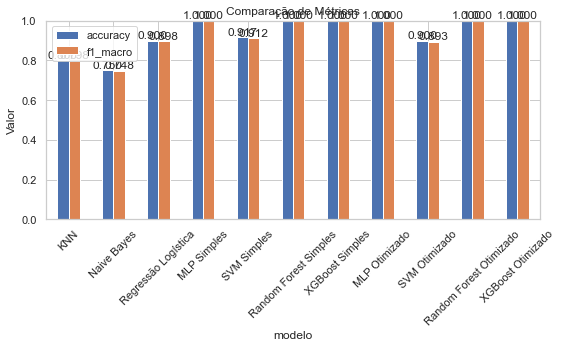

In [ ]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Gráfico de barras das métricas principais
# ==========================================================
plot_metric_bars(df_metrics, metrics=("accuracy", "f1_macro"))

In [ ]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Classification Reports completos
# ==========================================================
mostrar_classification_reports(modelos, X_val, y_val)


=== Classification Report: KNN ===
              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
           1       0.50      0.33      0.40         6
           2       0.71      1.00      0.83         5

    accuracy                           0.53        15
   macro avg       0.49      0.53      0.49        15
weighted avg       0.50      0.53      0.50        15


=== Classification Report: Naive Bayes ===
              precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.50      0.33      0.40         6
           2       0.83      1.00      0.91         5

    accuracy                           0.53        15
   macro avg       0.51      0.53      0.51        15
weighted avg       0.53      0.53      0.52        15


=== Classification Report: Regressão Logística ===
              precision    recall  f1-score   support

           0       0.25      0.25      0.25        

In [68]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Tabela detalhada por classe (para o melhor modelo)
# ==========================================================
modelo_principal = modelos["XGBoost Otimizado"]  
#modelo_principal = modelos["Random Forest Otimizado"]  
#modelo_principal = modelos["SVM Otimizado"]  

tabela_por_classe(modelo_principal, X_val, y_val)


,precision,recall,f1,support
0,0.600000,0.750000,0.666667,4
1,1.000000,0.666667,0.800000,6
2,0.833333,1.000000,0.909091,5


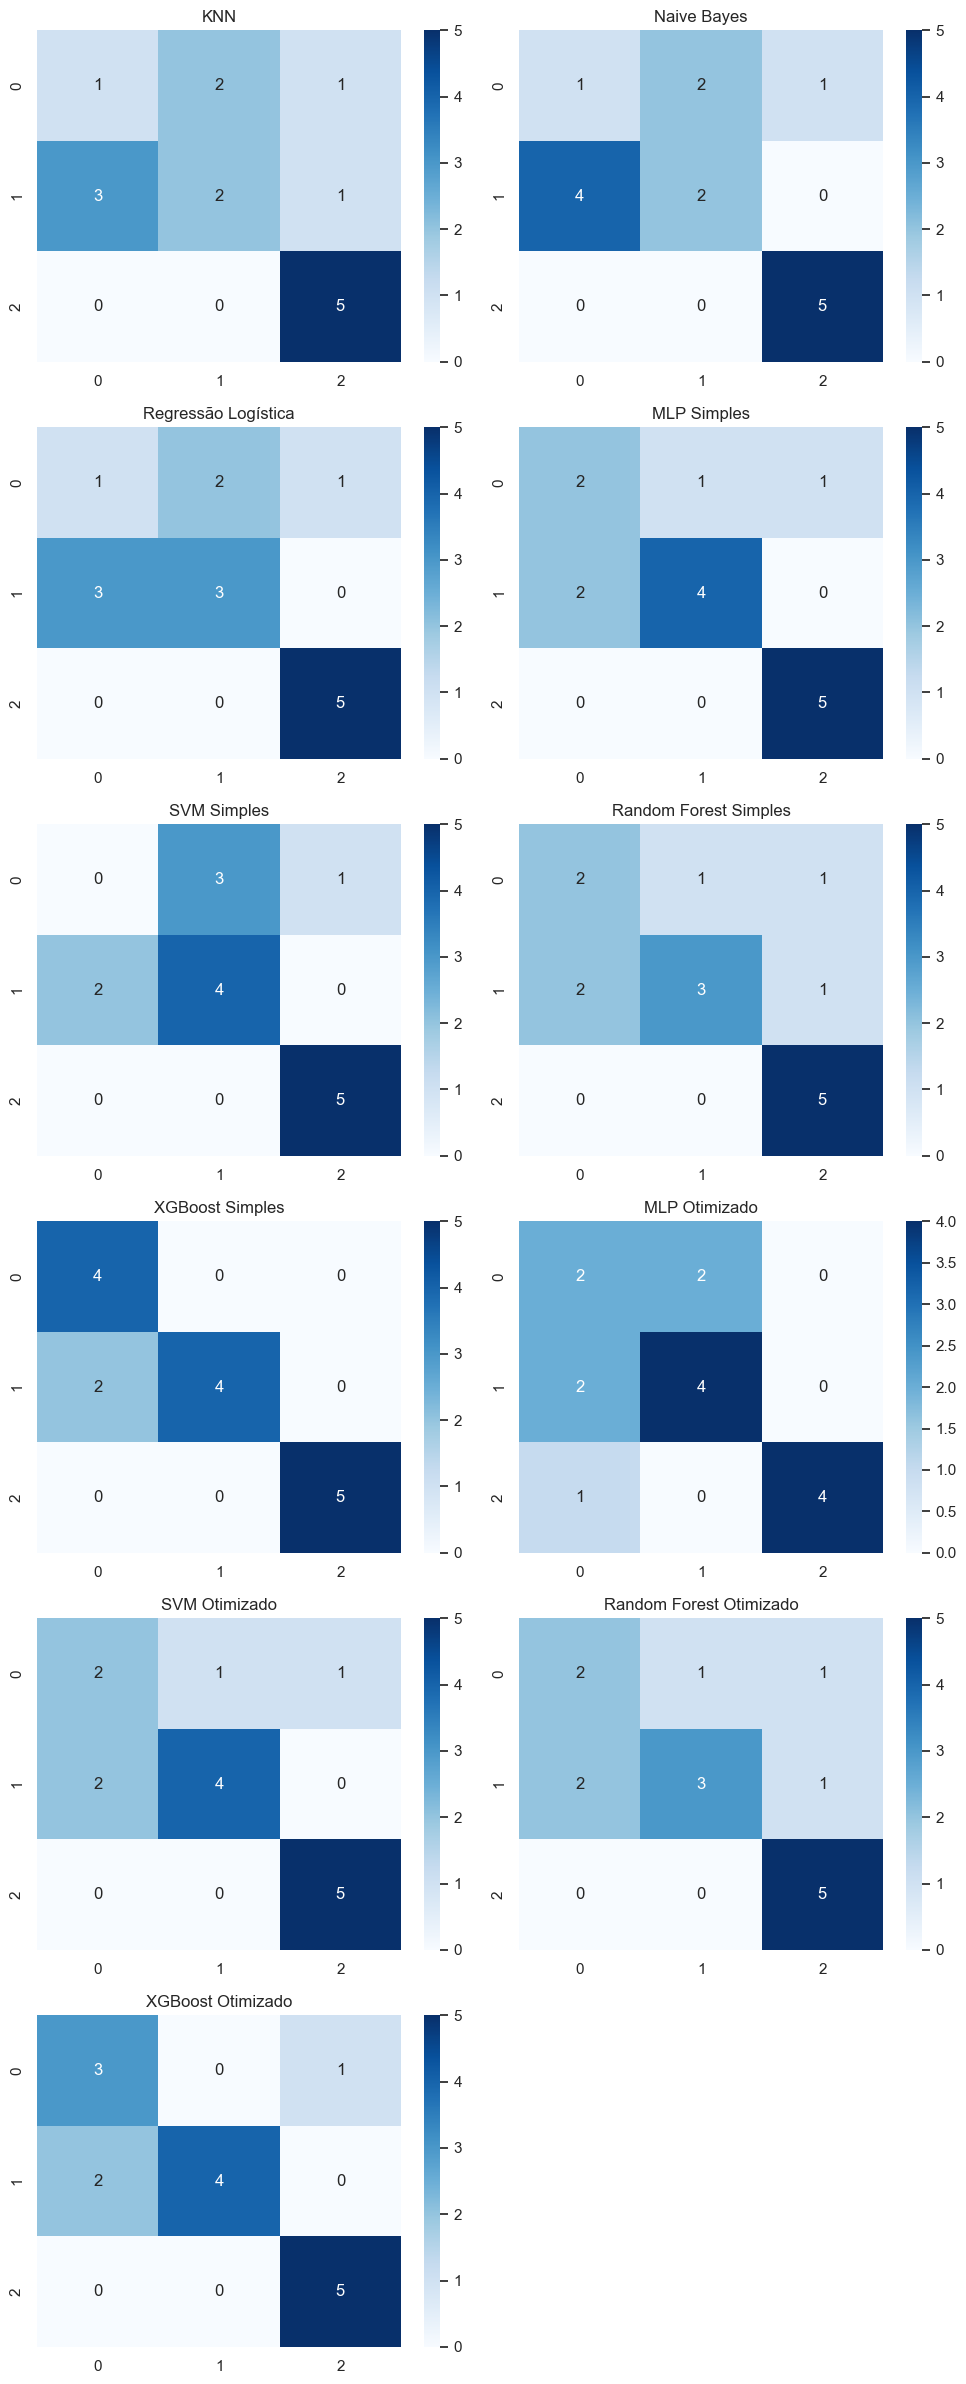

In [65]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Matrizes de confusão de todos os modelos
# ==========================================================
comparar_modelos_plot_confusao(
    modelos,
    X_val,
    y_val,
    labels=sorted(set(y_val)),
    normalize=False,
    max_per_row=2
)


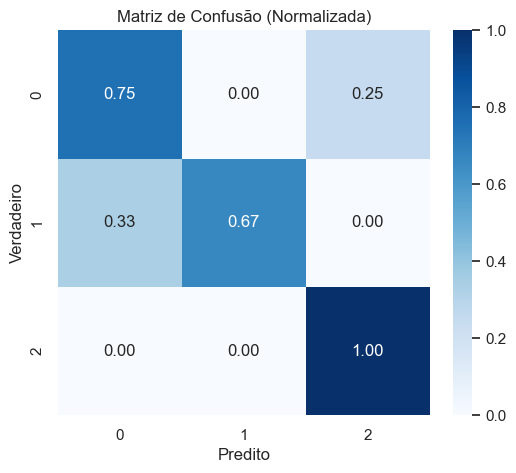

In [70]:
# =========================
# ANÁLISE DOS RESULTADOS - Matriz de confusão normalizada do melhor modelo
# =========================
plot_confusion_matrix_model(
    modelo_principal,
    X_val, y_val,
    labels=sorted(set(y_val)),
    normalize=True
)


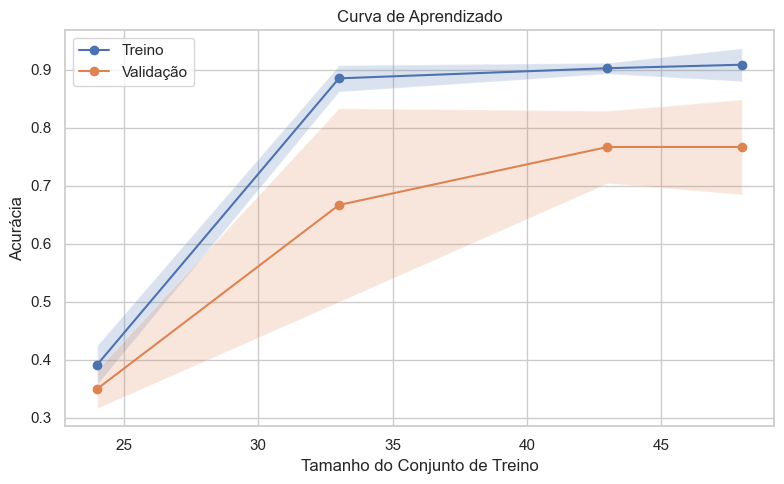

In [69]:
# =========================
# ANÁLISE DOS RESULTADOS - Curva de aprendizado para o melhor modelo
# =========================
from sklearn.model_selection import StratifiedKFold

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve_model(
    modelo_principal, 
    X_train, y_train,
    cv=cv5,
    train_sizes=[0.5, 0.7, 0.9, 1.0]
)


In [ ]:
# =========================
# ANÁLISE DOS RESULTADOS - Teste de McNemar (entre dois modelos)
# =========================
modelo_a = modelos["SVM Otimizado"]
modelo_b = modelos["MLP Otimizado"]

pvalor = teste_mcnemar(modelo_a, modelo_b, X_val, y_val)
print("p-valor McNemar:", pvalor)

if pvalor < 0.05:
    print("Diferença estatisticamente significativa!")
else:
    print("Não há diferença estatisticamente significativa.")

p-valor McNemar: 1.0
Não há diferença estatisticamente significativa.


In [ ]:
# =========================
# ANÁLISE DOS RESULTADOS - Curvas Precision–Recall multiclass (um gráfico por modelo)
# =========================
# plot_precision_recall_multiclass(modelos, X_val, y_val)

In [ ]:
# =========================
# ANÁLISE DOS RESULTADOS - Curvas ROC multiclass
# =========================
# plot_roc_multiclass(modelos, X_val, y_val)
modelo_principal

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=800, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=42,
              reg_alpha=0.1, reg_lambda=3, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
# =========================
# ANÁLISE DOS RESULTADOS - Importância de features (para o melhor modelo)
# =========================

# nomes das colunas usadas no treinamento
feature_names = list(X_train.columns)

df_imp = importancia_features_modelo(
    modelo_principal,
    X_val,
    y_val,
    feature_names=feature_names,
    top_k=20
)

df_imp


,feature,importance
0,eda_phasic_mean,0.170000
1,hr_std,0.136667
2,hr_mean,0.093333
3,inter_hrv_eda,0.093333
4,acc_mag_std,0.060000
5,eda_mean,0.040000
6,hrv_sdnn,0.040000
7,bvp_mean,0.036667
8,eda_std,0.036667
9,temp_mean,0.020000


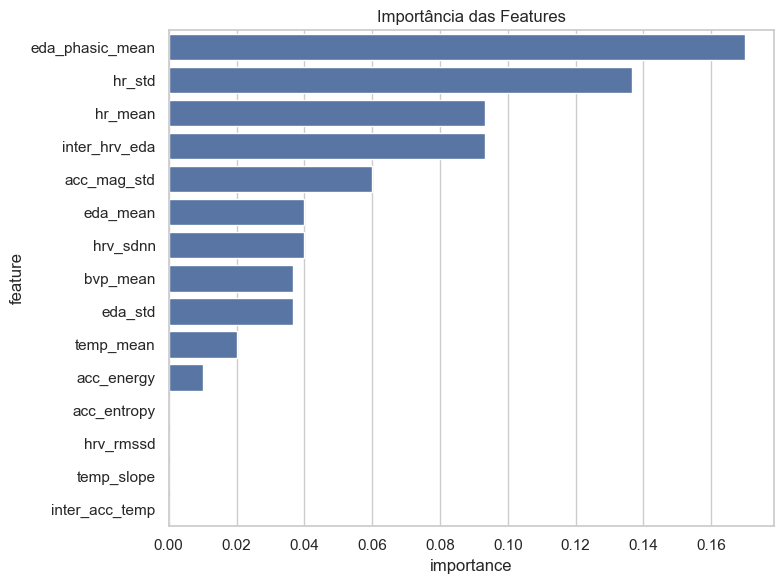

In [72]:
# =========================
# ANÁLISE DOS RESULTADOS - Gráfico de importância das features
# =========================
plot_importancia(df_imp, top_k=15)


In [73]:
# =========================
# ANÁLISE DOS RESULTADOS - Análise de erros por classe
# =========================
erro_df = analise_erros_por_classe(
    modelo_principal,
    X_val,
    y_val,
    feature_df=pd.DataFrame(X_val, columns=feature_names),
    labels=sorted(set(y_val))
)

erro_df


,classe,FN_count,FP_count,TP_count,FN_percent,FP_percent,FN_feature_mean,FP_feature_mean
0,0,1,2,3,0.066667,0.133333,"{'acc_energy': -0.5639102746610234, 'acc_entro...","{'acc_energy': 0.13211447031541354, 'acc_entro..."
1,1,2,0,4,0.133333,0.000000,"{'acc_energy': 0.13211447031541354, 'acc_entro...",{}
2,2,0,1,5,0.000000,0.066667,{},"{'acc_energy': -0.5639102746610234, 'acc_entro..."


In [63]:
gerar_submissao(
    modelo_principal,
    X_test,
    test_ids,
    label_encoder,
    nome_arquivo="submission.csv"
)


--- Gerando arquivo de submissão ---

✅ Submissão salva em: dataset\submission.csv
Ordem das colunas verificada: 0=STRESS, 1=AEROBIC, 2=ANAEROBIC
        Id  Predicted_0  Predicted_1  Predicted_2
0  U_19341     0.892079     0.076935     0.030986
1  U_54670     0.758531     0.197454     0.044015
2  U_21920     0.614071     0.332085     0.053844
3  U_58128     0.084216     0.214511     0.701273
4  U_73365     0.058559     0.718528     0.222913


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.892079,0.076935,0.030986
1,U_54670,0.758531,0.197454,0.044015
2,U_21920,0.614071,0.332085,0.053844
3,U_58128,0.084216,0.214511,0.701273
4,U_73365,0.058559,0.718528,0.222913
5,U_89682,0.620109,0.034421,0.345470
6,U_11501,0.907168,0.074139,0.018694
7,U_46423,0.741195,0.188919,0.069886
8,U_71408,0.926688,0.052488,0.020824
9,U_95655,0.375061,0.467441,0.157498
